In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn import preprocessing


from datetime import datetime
from datetime import date
from dateutil.relativedelta import relativedelta

from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, confusion_matrix,auc

In [2]:
# read in the json files
portfolio = pd.read_json('portfolio.json', orient='records', lines=True)
profile = pd.read_json('profile.json', orient='records', lines=True)
transcript = pd.read_json('transcript.json', orient='records', lines=True)

In [3]:
#transcript
print('The total number of columns and rows in the transcript data is: ', transcript.shape)

# profile
print('The total number of columns and rows in the profile data is: ', profile.shape)

#portfolio 
print('The total number of columns and rows in the portfolio data is: ', portfolio.shape)

The total number of columns and rows in the transcript data is:  (306534, 4)
The total number of columns and rows in the profile data is:  (17000, 5)
The total number of columns and rows in the portfolio data is:  (10, 6)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


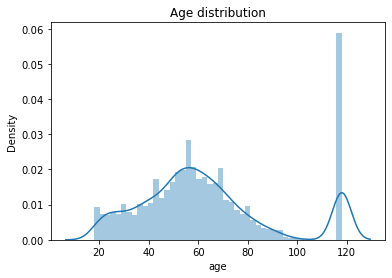

In [4]:
plt.title("Age distribution")
sns.distplot(a=profile['age'])
plt.show()

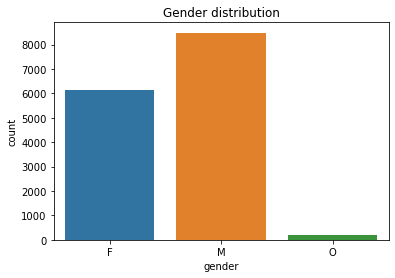

In [5]:
plt.title("Gender distribution")
sns.countplot(x='gender', data=profile)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


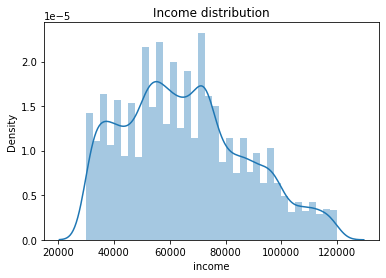

In [6]:
plt.title("Income distribution")
sns.distplot(a=profile['income'])
plt.show()

# Cleaning datasets

### Description
Portfolio.json file has 6 columns: reward, channels, diffuculty, offer_type, and id
### Steps to clean:
- Check dataset content
- Check data types
- Check null/empty cells
- Drop duplicate values, if applicable
- Fill cell values, if applicable
- Convert channels to numerical values

In [7]:
# Check dataset content
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
# Check data types
portfolio.dtypes

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

In [9]:
portfolio['id'].value_counts()

ae264e3637204a6fb9bb56bc8210ddfd    1
4d5c57ea9a6940dd891ad53e9dbe8da0    1
9b98b8c7a33c4b65b9aebfe6a799e6d9    1
fafdcd668e3743c1bb461111dcafc2a4    1
0b1e1539f2cc45b7b9fa7c272da2e1d7    1
2906b810c7d4411798c6938adc9daaa5    1
2298d6c36e964ae4a3e7e9706d1fb8c2    1
5a8bc65990b245e5a138643cd4eb9837    1
f19421c1d4aa40978ebb69ca19b0e20d    1
3f207df678b143eea3cee63160fa8bed    1
Name: id, dtype: int64

### We have columns: channels, offer_type and id to clean up

In [10]:
# cleaning up channels column, by creating individual columns for each channel the user receives offers
channels = ['email', 'web', 'social', 'mobile']
r = ['email', 'mobile', 'social']
for channel in channels:
    portfolio[channel] = portfolio['channels'].apply(lambda x: 1.0 if channel in x else 0.0)
portfolio = portfolio.drop(columns='channels', axis=1)
portfolio.head(12)


,reward,difficulty,duration,offer_type,id,email,web,social,mobile
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0.0,1.0,1.0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1.0,1.0,1.0,1.0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1.0,1.0,1.0,1.0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1.0,0.0,1.0,1.0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1.0,1.0,1.0,1.0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1.0,1.0,0.0,1.0


In [11]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [12]:
# cleaning up offer_type
portfolio['offer_type'] = portfolio['offer_type'].map({'bogo':1, 'discount':2, 'informational': 3})
portfolio.head()

,reward,difficulty,duration,offer_type,id,email,web,social,mobile
0,10,10,7,1,ae264e3637204a6fb9bb56bc8210ddfd,1.0,0.0,1.0,1.0
1,10,10,5,1,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,0,0,4,3,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,5,5,7,1,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,5,20,10,2,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,1.0,0.0,0.0


In [13]:
# cleanup id column
len(portfolio['id'].unique())
portfolio.rename(columns={'id':'offer id'}, inplace=True)

In [14]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [15]:
len(profile['id'].unique())

17000

In [16]:
profile.dtypes

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

### change type for gender and id

In [17]:
profile['membership_date'] = pd.to_datetime(profile.became_member_on, format='%Y%m%d', errors='coerce')
profile1 = profile.drop(columns='became_member_on', axis=1)

In [18]:
for index, row in profile1.iterrows():
    now = date.today()
    rdelta = relativedelta(now, row['membership_date'])
    
    profile1.loc[index, 'years_of_service'] = rdelta.years
      

profile1.head()

,gender,age,id,income,membership_date,years_of_service
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,2017-02-12,4.0
1,F,55,0610b486422d4921ae7d2bf64640c50b,112000.0,2017-07-15,3.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,2018-07-12,2.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017-05-09,3.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,NaN,2017-08-04,3.0


In [19]:
profile1['gender'] = profile1['gender'].fillna('O')

In [20]:
profile1.rename(columns={'id':'person'}, inplace=True)
profile1['gender'].value_counts()
profile1['gender'] = profile1['gender'].map({'M':1, 'F':2, 'O': 3})

In [21]:
# income column
profile1['income'] = profile1['income'].fillna(profile1['income'].mean())

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


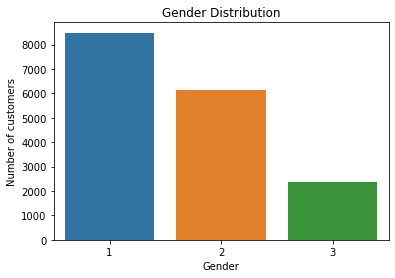

In [22]:
# plt.figure(figsize=(16, 10))
sns.countplot(profile1['gender'])
plt.title('Gender Distribution')
plt.ylabel('Number of customers')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

In [23]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [24]:
for col in ['amount', 'reward', 'offer id', 'offer_id']:
    transcript[col] = transcript['value'].apply(lambda x: x[col] if col in x else None)

In [25]:
for index, row in transcript.iterrows():
    if row["offer id"] is None and row["offer_id"] is not None:
        transcript.loc[index, 'offer id'] = row["offer_id"]

In [26]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [27]:
transcript[transcript.event == 'transaction']

,person,event,value,time,amount,reward,offer id,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,NaN,None,None
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,NaN,None,None
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,NaN,None,None
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,NaN,None,None
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,NaN,None,None
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,1.59,NaN,None,None
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,9.53,NaN,None,None
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,3.61,NaN,None,None
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,3.53,NaN,None,None


In [28]:
transcript[transcript.event == 'offer completed']

,person,event,value,time,amount,reward,offer id,offer_id
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,NaN,2.0,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,NaN,5.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,9b98b8c7a33c4b65b9aebfe6a799e6d9
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,NaN,10.0,ae264e3637204a6fb9bb56bc8210ddfd,ae264e3637204a6fb9bb56bc8210ddfd
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,NaN,10.0,4d5c57ea9a6940dd891ad53e9dbe8da0,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...,...,...,...
306475,0c027f5f34dd4b9eba0a25785c611273,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2
306497,a6f84f4e976f44508c358cc9aba6d2b3,offer completed,{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...,714,NaN,3.0,2298d6c36e964ae4a3e7e9706d1fb8c2,2298d6c36e964ae4a3e7e9706d1fb8c2
306506,b895c57e8cd047a8872ce02aa54759d6,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4
306509,8431c16f8e1d440880db371a68f82dd0,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,714,NaN,2.0,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4


In [29]:
transcript[transcript.event == 'offer viewed']

,person,event,value,time,amount,reward,offer id,offer_id
12650,389bc3fa690240e798340f5a15918d5c,offer viewed,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,None
12651,d1ede868e29245ea91818a903fec04c6,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,None
12652,102e9454054946fda62242d2e176fdce,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None
12653,02c083884c7d45b39cc68e1314fec56c,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},0,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,None
12655,be8a5d1981a2458d90b255ddc7e0d174,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},0,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,None
...,...,...,...,...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,None
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,None
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,NaN,NaN,3f207df678b143eea3cee63160fa8bed,None


In [30]:
transcript[transcript.event == 'offer received']

,person,event,value,time,amount,reward,offer id,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,None
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,None
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,None
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,None
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,None
...,...,...,...,...,...,...,...,...
257882,d087c473b4d247ccb0abfef59ba12b0e,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,None
257883,cb23b66c56f64b109d673d5e56574529,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},576,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,None
257884,6d5f3a774f3d4714ab0c092238f3a1d7,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},576,NaN,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,None
257885,9dc1421481194dcd9400aec7c9ae6366,offer received,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},576,NaN,NaN,ae264e3637204a6fb9bb56bc8210ddfd,None


In [31]:
transcript = transcript.drop(columns=['value','offer_id'])
transcript.head()

,person,event,time,amount,reward,offer id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


#### Do we need duplicate person's event? If yes, next..
#### drop duplicate persons in transcript
#### Replace columns id with person in profile & portfolio
#### Check for any blank cells

In [32]:
# Merge transcript with porfolio
new_df = pd.merge(profile1, transcript, on='person',how='inner')

In [33]:
# Merge new dataFrame with profile
df = new_df.merge(portfolio, on="offer id", how='left')

In [34]:
df.head()

,gender,age,person,income,membership_date,years_of_service,event,time,amount,reward_x,offer id,reward_y,difficulty,duration,offer_type,email,web,social,mobile
0,3,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,4.0,offer received,168,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,2.0,1.0,1.0,0.0,1.0
1,3,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,4.0,offer viewed,216,NaN,NaN,2906b810c7d4411798c6938adc9daaa5,2.0,10.0,7.0,2.0,1.0,1.0,0.0,1.0
2,3,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,4.0,offer received,336,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,2.0,1.0,1.0,0.0,0.0
3,3,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,4.0,offer viewed,348,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,20.0,10.0,2.0,1.0,1.0,0.0,0.0
4,3,118,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017-02-12,4.0,transaction,360,0.35,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def user_story(data):
    received_offer_results = list()
    new_received_offer_results = list()
    
    received_offer = data[data.event == 'offer received']
    viewed_offer = data[data.event == 'offer viewed']
    completed_offer = data[data.event == 'offer completed']
    
    if received_offer.shape[0] == 0:
        return None
    
    for i, row in received_offer.iterrows():
        story = dict()
        story['time'] = row.time
        story['offer id'] = row['offer id']
        story['expected endtime'] = (row.time + row.duration)
        story_done = completed_offer[(completed_offer['offer id'] == row['offer id']) & (completed_offer.time >= row.time) &
                               (completed_offer.time <= (row.time + row.duration))]
        
        if story_done.shape[0] > 0:
            story['completed'] = 1
            story['done'] = story_done.time.iloc[0]
        else:
            story['completed'] = 0
            story['done'] = story['expected endtime']
        received_offer_results.append(story)
        
    new_received_df = received_offer.merge(pd.DataFrame(received_offer_results),on=['time', 'offer id'],how='left')
        
    for i, row in new_received_df.iterrows():
        story = dict()
        story['time'] = row.time
        story['offer id'] = row['offer id']
        story_view = viewed_offer[(viewed_offer['offer id'] == viewed_offer['offer id']) & (viewed_offer.time >= row.time) & (viewed_offer.time <= row.done)]
        if story_view.shape[0] > 0:
            story['view time'] = story_view.time.iloc[0]
            if (story_view.time.iloc[0] <= row.done) and row.completed:
                story['offer success'] = 1
            else:
                story['offer success'] = 0
        else:
            story['offer success'] = 0
        new_received_offer_results.append(story)
    
    return new_received_df.merge(pd.DataFrame(new_received_offer_results), on=['time', 'offer id'], how='left')

In [36]:
def model(df):
    return df.groupby('person').apply(user_story).reset_index(drop=True)

In [37]:
%time model = model(df)

CPU times: user 6min 16s, sys: 3.5 s, total: 6min 19s
Wall time: 6min 23s


In [38]:
model.head()

,gender,age,person,income,membership_date,years_of_service,event,time,amount,reward_x,...,offer_type,email,web,social,mobile,expected endtime,completed,done,offer success,view time
0,1,33,0009655768c64bdeb2e877511632db8f,72000.0,2017-04-21,4.0,offer received,168,NaN,NaN,...,3.0,1.0,0.0,1.0,1.0,171.0,0,171.0,0,NaN
1,1,33,0009655768c64bdeb2e877511632db8f,72000.0,2017-04-21,4.0,offer received,336,NaN,NaN,...,3.0,1.0,1.0,0.0,1.0,340.0,0,340.0,0,NaN
2,1,33,0009655768c64bdeb2e877511632db8f,72000.0,2017-04-21,4.0,offer received,408,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,413.0,0,413.0,0,NaN
3,1,33,0009655768c64bdeb2e877511632db8f,72000.0,2017-04-21,4.0,offer received,504,NaN,NaN,...,2.0,1.0,1.0,1.0,1.0,514.0,0,514.0,0,NaN
4,1,33,0009655768c64bdeb2e877511632db8f,72000.0,2017-04-21,4.0,offer received,576,NaN,NaN,...,2.0,1.0,1.0,0.0,1.0,583.0,1,576.0,0,NaN


# Data Visualization

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3710: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


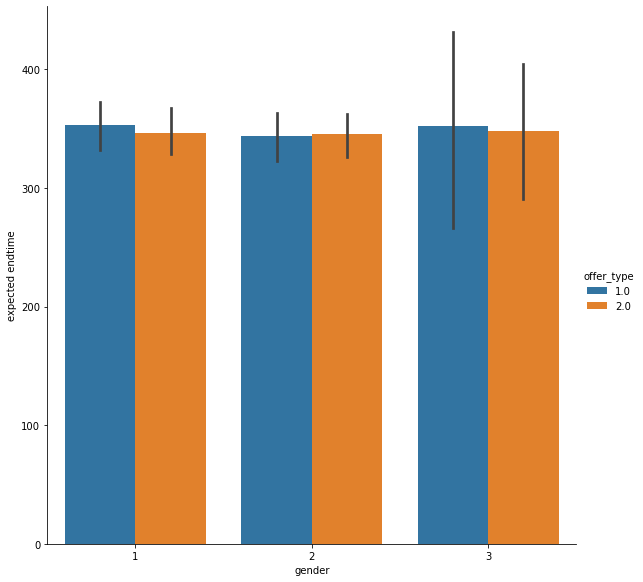

In [39]:
success_df=model[model['offer success'] == 1]

sns.factorplot(x='gender', y='expected endtime' , data=success_df, hue='offer_type',size=8,kind='bar', aspect=1)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


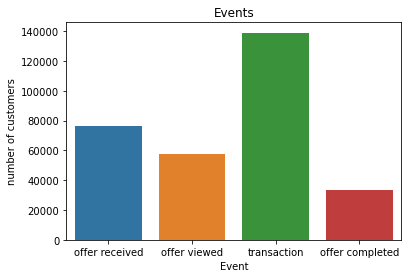

In [40]:
sns.countplot(df['event'])
plt.title('Events')
plt.ylabel('number of customers')
plt.xlabel('Event')
plt.xticks(rotation = 0)
plt.show();

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


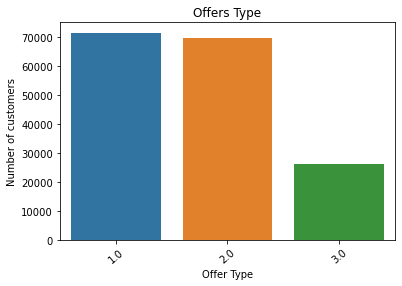

In [41]:
sns.countplot(df[df['offer_type'] != 0]['offer_type'])
plt.title('Offers Type')
plt.ylabel('Number of customers')
plt.xlabel('Offer Type')
plt.xticks(rotation = 40)
plt.show();

In [42]:
top_users = df[(df['event'] == 'offer completed') | (df['event'] == 'transaction')].groupby(['person', 'event'])['amount'].sum().reset_index()
top_users = top_users.sort_values('amount', ascending=False).head()
top_users

,person,event,amount
6956,3c8d541112a74af99e88abbd0692f00e,transaction,1608.69
27773,f1d65ae63f174b8f80fa063adcaa63b7,transaction,1365.66
20207,ae6f43089b674728a50b8727252d3305,transaction,1327.74
11265,626df8678e2a4953b9098246418c9cfa,transaction,1321.42
13252,73afdeca19e349b98f09e928644610f8,transaction,1319.97


# Training our model

In [43]:
def cleaned_data(df):
    
    df.drop('membership_date',axis=1, inplace=True)    
    
   
    ids = df['offer id'].unique().tolist()
    id_map = dict( zip(ids,range(len(ids))) )
    df.replace({'offer id': id_map},inplace=True)
    
    
    persons = df['person'].unique().tolist()
    person = dict( zip(persons,range(len(persons))) )
    df.replace({'person': person},inplace=True)
    

    label_encoder = preprocessing.LabelEncoder()
    df['event'] = label_encoder.fit_transform(df['event'])

    return df

In [44]:
df = cleaned_data(model)

In [45]:
df = df.drop(['person', 'age','offer id','gender','view time', 'event', 'amount', 'reward_x'], axis=1)

In [46]:
dx = df.loc[:, df.columns != 'offer success']
label = df['offer success']

X_train, X_test, y_train, y_test = train_test_split(dx, label, test_size = 0.2, random_state = 0)

print("Training data has {} rows".format(X_train.shape[0]))
print("Testing data has {} rows".format(X_test.shape[0]))

Training data has 61021 rows
Testing data has 15256 rows


### Benchmark Model - GradientBoostingClassifier.

. roc_auc_score - Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction
scores
. accuracy_score - The number of correct predictions made divided by the total number of predictions
made
. f1_score - Weighted average of the precision and recall, where an F1 score reaches its best value at 1


In [47]:
benchmark_train = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1,random_state=0).fit(X_train, y_train)
benchmark_train_score = benchmark_train.score(X_train, y_train)


benchmark_test = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
max_depth=1,random_state=0).fit(X_test, y_test)
benchmark_test_score = benchmark_test.score(X_test, y_test)


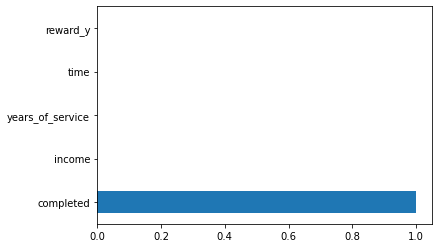

In [48]:
#plot graph of important features 
features = pd.Series(benchmark_test.feature_importances_, index=X_test.columns)
features.nlargest(5).plot(kind='barh')
plt.show()

In [49]:
benchmark = {'Benchmark Model': ['GradientBoostingClassifier'], 'Train Score':[benchmark_train_score], 'Test Score': [benchmark_test_score]}
benchmark_df = pd.DataFrame(benchmark)
benchmark_df

,Benchmark Model,Train Score,Test Score
0,GradientBoostingClassifier,0.979925,0.981319


In [50]:
xgboost = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=6,
 min_child_weight=4,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.9,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=3,
 scale_pos_weight=2,
 seed=30)

In [51]:
xgboost.fit(X_test, y_test)

xgboost_predict = xgboost.predict(X_test)

xgboost_accuracy_score_test = accuracy_score(xgboost_predict, y_test)
xgboost_roc_auc_score_test = roc_auc_score(xgboost_predict, y_test)
xgboost_f1_score_test= f1_score(xgboost_predict, y_test, average='macro')


print("Accuracy Score (Test) : %.4g" % xgboost_accuracy_score_test)
print("AUC Score (Test) : %.4g" % xgboost_roc_auc_score_test)
print("F1 Score (Test): %.4g" % xgboost_f1_score_test)

Accuracy Score (Test) : 0.9991
AUC Score (Test) : 0.9782
F1 Score (Test): 0.9886


In [52]:
xgboost.fit(X_train, y_train)

xgboost_predict = xgboost.predict(X_train)

xgboost_accuracy_score_train = accuracy_score(xgboost_predict, y_train)
xgboost_roc_auc_score_train = roc_auc_score(xgboost_predict, y_train)
xgboost_f1_score_train= f1_score(xgboost_predict, y_train, average='macro')


print("Accuracy Score (Train) : %.4g" % xgboost_accuracy_score_train)
print("AUC Score (Train): %f" % xgboost_roc_auc_score_train)
print("F1 Score (Train): %f" % xgboost_f1_score_train)       

Accuracy Score (Train) : 0.9954
AUC Score (Train): 0.912239
F1 Score (Train): 0.946128


In [53]:
xgboostModel = {'Xgboost Model': ['Xgboost Model'], 'Train Score':[xgboost_accuracy_score_train], 'Test Score': [xgboost_accuracy_score_test]}
xgboost_model_df = pd.DataFrame(xgboostModel)
xgboost_model_df

,Xgboost Model,Train Score,Test Score
0,Xgboost Model,0.995379,0.999148


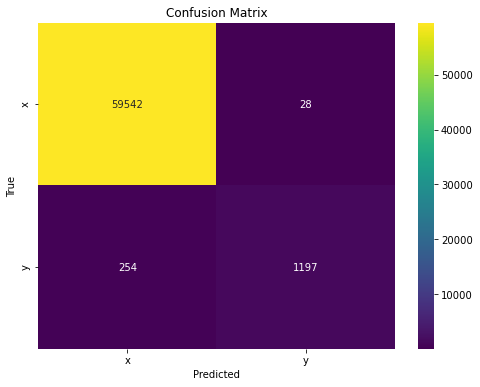

In [54]:
# Confusion matrix
predict = xgboost.predict(X_train)
con = confusion_matrix(predict, y_train)

labels = ['x', 'y']
plt.figure(figsize=(8,6))
sns.heatmap(con, xticklabels = labels, yticklabels = labels, annot = True, fmt='d', cmap="viridis", vmin = 0.2);
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()